In [1]:
import pybaseball as pb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.ticker
import os

In [2]:
pb.cache.enable()

In [3]:
batters_2025 = pb.batting_stats(2025)

In [4]:
batters_2025['WAR/game'] = batters_2025['WAR']/batters_2025['G']
games_left =162- max(batters_2025['G'])
batters_2025['WAR_left'] = batters_2025['WAR/game']*games_left
batters_2025['proj_total_war'] = batters_2025['WAR']+batters_2025['WAR_left']

In [5]:
batters_1 = pb.batting_stats(start_season = 1920, end_season = 2024 ,league = 'AL')

In [6]:
batters_2 = pb.batting_stats(start_season = 1920, end_season = 2024 ,league = 'NL')

In [7]:
batters_df  = pd.concat([batters_1, batters_2])

In [8]:
batters_df = batters_df.drop_duplicates()

In [9]:
batters_df = batters_df.loc[:,['IDfg','Season','Name','Age','WAR']]

In [10]:
batters_2025_trimmed = batters_2025.loc[:,['IDfg','Name', 'Season','Age','proj_total_war']]
batters_2025_trimmed=batters_2025_trimmed.rename(columns={'proj_total_war':'WAR'})

In [11]:
all_batters = pd.concat([batters_df, batters_2025_trimmed])

In [12]:
all_batters.to_csv('qualified.csv')

In [13]:
all_batters['Age2'] = all_batters['Age']**2

In [14]:
from statsmodels.formula.api import mixedlm

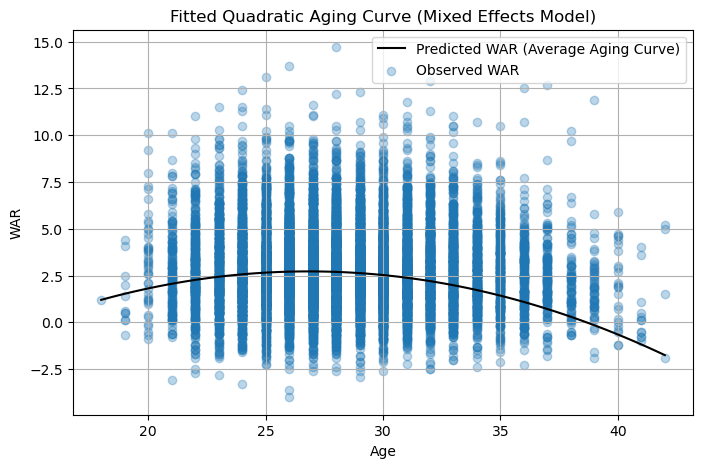

In [15]:
batter_mixed = mixedlm("WAR ~ Age + Age2", data=all_batters, groups=all_batters["IDfg"]).fit(reml=False)
intercept = batter_mixed.params['Intercept']
coef_age = batter_mixed.params['Age']
coef_age2 = batter_mixed.params['Age2']
age_range = np.linspace(all_batters['Age'].min(), all_batters['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)', color='black')
plt.scatter(all_batters['Age'], all_batters['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Mixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

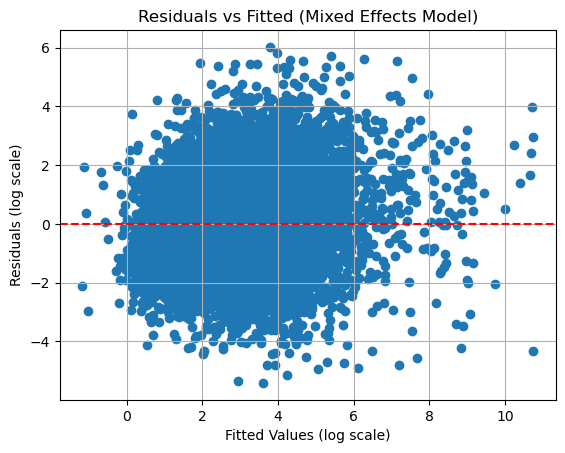

In [16]:
plt.scatter(batter_mixed.fittedvalues, batter_mixed.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (log scale)')
plt.ylabel('Residuals (log scale)')
plt.title('Residuals vs Fitted (Mixed Effects Model)')
plt.grid(True)
plt.show()

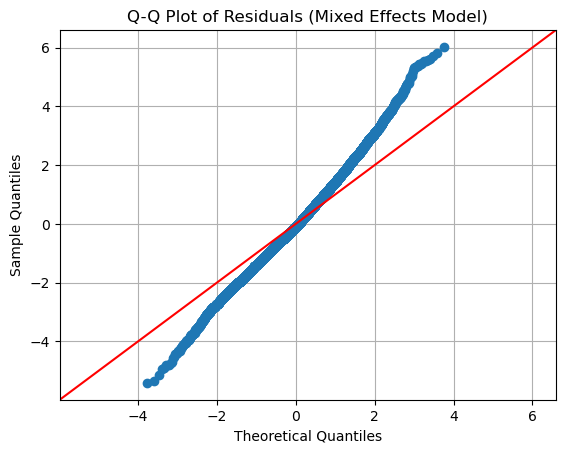

In [19]:
from statsmodels.api import qqplot
qqplot(batter_mixed.resid, line='45')
plt.title('Q-Q Plot of Residuals (Mixed Effects Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Optimal lambda for Box-Cox: 0.368


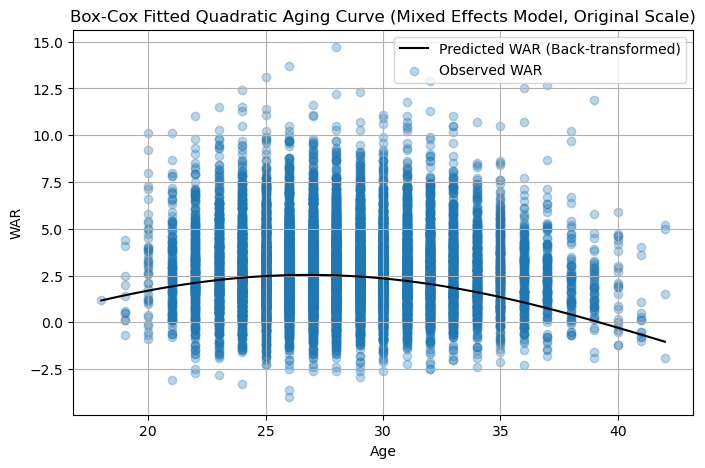

In [20]:
from scipy.stats import boxcox

shift = abs(all_batters['WAR'].min()) + 1
war_shifted = all_batters['WAR'] + shift

all_batters['WAR_boxcox'], lam = boxcox(war_shifted)
print(f'Optimal lambda for Box-Cox: {lam:.3f}')

from statsmodels.regression.mixed_linear_model import MixedLM
batter_mixed_boxcox = MixedLM.from_formula(
    "WAR_boxcox ~ Age + Age2",
    groups=all_batters["IDfg"],
    data=all_batters
).fit(reml=False)

from scipy.special import inv_boxcox

intercept = batter_mixed_boxcox.params['Intercept']
coef_age = batter_mixed_boxcox.params['Age']
coef_age2 = batter_mixed_boxcox.params['Age2']
predicted_transformed_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
age_range = np.linspace(all_batters['Age'].min(), all_batters['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
predicted_war_original = inv_boxcox(predicted_transformed_war, lam) - shift

plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war_original, label='Predicted WAR (Back-transformed)', color='black')
plt.scatter(all_batters['Age'], all_batters['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Box-Cox Fitted Quadratic Aging Curve (Mixed Effects Model, Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

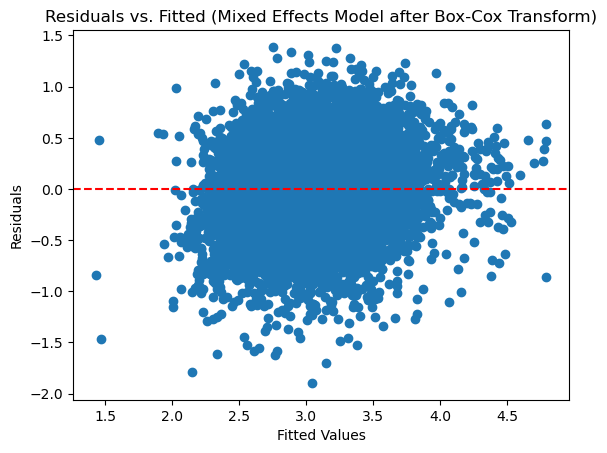

In [21]:
plt.scatter(batter_mixed_boxcox.fittedvalues, batter_mixed_boxcox.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Mixed Effects Model after Box-Cox Transform)')
plt.show()

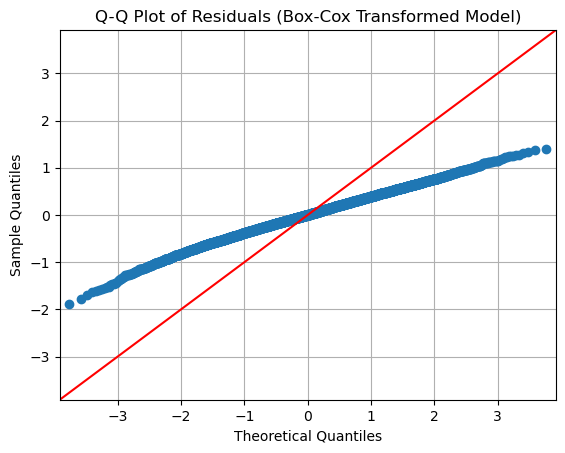

In [22]:
qqplot(batter_mixed_boxcox.resid, line='45')
plt.title('Q-Q Plot of Residuals (Box-Cox Transformed Model)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [25]:
print(batter_mixed_boxcox.aic,batter_mixed_boxcox.bic)

17211.330628097858 17248.290186334754


In [26]:
print(batter_mixed.aic, batter_mixed.bic)

48346.94507359185 48383.90463182875


In [ ]:
final_model = MixedLM.from_formula(
    "WAR_boxcox ~ Age + Age2",
    groups=all_batters["IDfg"],
    data=all_batters
).fit(reml=True)

C:\Users\dylan\AppData\Local\Temp\ipykernel_15612\686310563.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


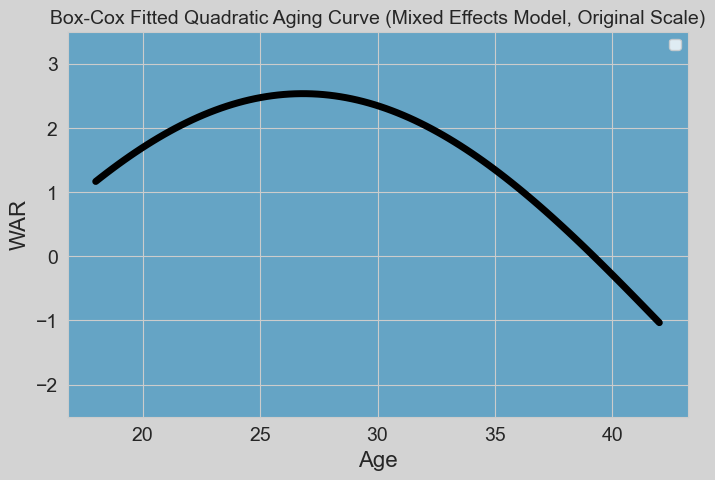

In [41]:
intercept = final_model.params['Intercept']
coef_age = final_model.params['Age']
coef_age2 = final_model.params['Age2']
predicted_transformed_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
age_range = np.linspace(all_batters['Age'].min(), all_batters['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
predicted_war_original = inv_boxcox(predicted_transformed_war, lam) - shift

plt.figure(figsize=(8,5))

ax = sns.lineplot(x=age_range, y=predicted_war_original, linewidth = 5, color='black')
plt.gca().set_facecolor("#65a4c5")
plt.gcf().set_facecolor('#d3d3d3')
plt.xlabel('Age', fontsize = 16)
plt.ylabel('WAR', fontsize = 16)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.ylim((-2.5,3.5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Box-Cox Fitted Quadratic Aging Curve (Mixed Effects Model, Original Scale)', fontsize = 14)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\dylan\AppData\Local\Temp\ipykernel_15612\3644524651.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


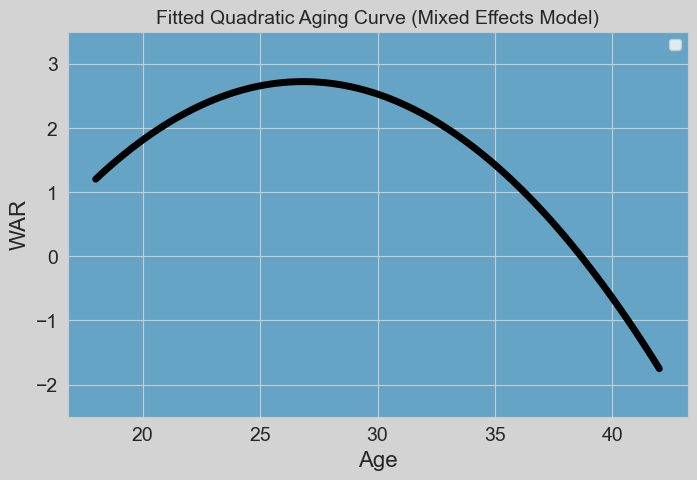

In [34]:
final_mixed = mixedlm("WAR ~ Age + Age2", data=all_batters, groups=all_batters["IDfg"]).fit(reml=True)
intercept = final_mixed.params['Intercept']
coef_age = final_mixed.params['Age']
coef_age2 = final_mixed.params['Age2']
age_range = np.linspace(all_batters['Age'].min(), all_batters['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.lineplot(x=age_range, y=predicted_war, linewidth = 5, color='black')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.gca().set_facecolor("#65a4c5")
plt.gcf().set_facecolor('#d3d3d3')
plt.ylim((-2.5,3.5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Age', fontsize = 16)
plt.ylabel('WAR', fontsize = 16)
plt.title('Fitted Quadratic Aging Curve (Mixed Effects Model)', fontsize = 14)
plt.legend()
plt.grid(True)
plt.show()